## 简答题

1. Glorot初始化和He初始化为了解决什么问题

- 在反向传播的过程中梯度消失和梯度爆炸问题

2. 是否可以将所有权重初始化为相同的值（只要该值是使用He初始化随机选择的）

- 不可以，设置为相同的值的话，神经元做的事会变成一模一样，所有神经元计算出的梯度也是完全相同的，造成对称权重问题

3. 将偏置项初始化为0可以吗

- 可以，这样在神经元输出完全由权重决定，模型从中性的状态开始学习，通过梯度下降来找到每个偏置应有的最佳值

4. 总结下讨论过的激活函数，并讲述在什么情况下使用它们

- sigmoid\tanh\softmax函数 使用Glorot初始化
- ReLU及其变体使用He初始化
- SELU函数使用LeCun初始化

5. 如果在使用SGD优化器时将momentum超参数设置得太接近1（例如0.99999)会发生什么情况

- 方向极难改变，对梯度不敏感，遇到损失曲面弯曲会猛烈冲出轨道造成震荡，需要很多的迭代次数才能有较好的结果

6. 列举三种能产生稀疏模型得方法

- L1正则化：L1范数在零点处不可导
- ReLU函数激活：一大部分神经网络能够因为输入为负值而被设置为0
- 权重剪枝：通过有选择地将权重值设置为0，并确保在后续微调中保持为0，从而创造出稀疏性

7. dropout会减慢训练速度吗？它会减慢推理（即对新实例进行预测）速度吗？MC dropout呢？
- 会，但通常影响很小
- 不会，标准的dropout在推理时会被完全关闭
- MC dropout会明显减慢推理速度



## 编程题

在CIFAR10图像数据集上练习训练深度神经网络：

CIFAR-10数据集，又称加拿大高等研究院数据集（Canadian Institute for Advanced Research）是一个常用于训练机器学习和计算机视觉算法的图像集合。它是最广泛使用的机器学习研究数据集之一。

CIFAR-10数据集包含60,000张32×32像素的彩色图像，分为10个不同的类别。这10个类别分别是飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车，每个类别有6,000张图片。

飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车 对应的分类编码是0，1，2，3，4，5，6，7，8，9


1. 构建一个DNN，使其包含20个隐藏层，每个隐藏层包含100个神经元。使用He初始化和Swish激活函数。
2. 使用Nadam优化和早停技术，在CIFAR10数据集上训练网络。可以使用tf.keras.datasets.cifar10.load_data()加载数据。该数据集由10个类别的60000幅32×32像素的彩色图像（用于训练的50000个，用于测试的10000个）组成，因此需要一个具有10个神经元的softmax输出层。记住，每次更改模型的架构或超参数时，都要找寻正确的学习率。
3. 尝试添加批量归一化并比较学习曲线：收敛速度是否比以前快？会产生更好的模型吗？它如何影响训练速度？
4. 尝试用SELU替换批量归一化，并进行必要的调整以确保网络是自归一化的（即归一化输入特征，使用LeCun正态初始化，确保DNN仅仅包含一系列的密集层等）
5. 尝试使用Alpha dropout正则化模型。然后，在不重新训练模型的情况下，看看是否可以使用MC dropout获得更好的精度。
6. 使用1周期调度来重新训练模型，看看它是否可以提高训练速度和模型精度。

加载数据的代码： tf.keras.datasets.cifar10.load_data()

下载失败的解决方案：
1. 下载文件： cifar-10-python.tar.gz （会把文件发群里）
2. 将文件 cifar-10-python.tar.gz 重命名为 cifar-10-batches-py.tar.gz
3. 并复制到类似 C:\Users\某个用户名或者管理员\.keras\datasets 的路径。将 某个用户名或者管理员 替换为你的用户名。如果是 Linux/Macos 系统，则应为 /home/某个用户名或者管理员/.keras/datasets。

In [1]:
# 加载数据的代码
import tensorflow as tf
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
# 查看数据集形状
print("训练集图片形状:", X_train_full.shape) # 应该是 (50000, 32, 32, 3)
print("训练集标签形状:", y_train_full.shape) # 应该是 (50000, 1)

训练集图片形状: (50000, 32, 32, 3)
训练集标签形状: (50000, 1)


In [2]:
x_train_full = X_train_full.astype('float32') / 255.0
x_test = X_test.astype('float32') / 255.0

In [3]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid = train_test_split(x_train_full,y_train_full ,test_size=0.1,random_state= 42)

In [4]:
# 按0-9顺序定义类别：飞机、汽车、鸟类、猫、鹿、狗、青蛙、马、船和卡车
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

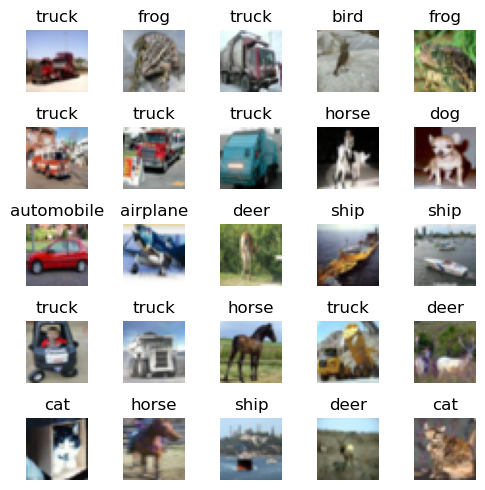

In [22]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 5
ncols = 5

plt.figure(figsize=(5, 5))


random_indices = np.random.choice(len(X_train_full), nrows * ncols, replace=False)  # 无放回随机抽索引

for i, idx in enumerate(random_indices):
    plt.subplot(nrows, ncols, i+1)
    img = X_train_full[idx]
    label = y_train_full[idx, 0]
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

# 调整子图之间的间距，防止标题等重叠
plt.tight_layout()
plt.show()

In [14]:
# 创建模型
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(32, 32, 3)))
model.add(tf.keras.layers.Normalization()) # 标准化，需要在编译前适配数据
model.add(tf.keras.layers.Flatten()) # 因为Dense层需要输入扁平化数据

for layer in range(20):
    model.add(tf.keras.layers.Dense(100,kernel_initializer="he_normal",activation="swish"))  # todo:使用了He和swish
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
# 这里需要找下最佳学习率
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=2,min_lr=1e-6,verbose=1)

In [16]:
tf.keras.backend.clear_session()
# 模型编译(编译之前适配)、拟合

optimizer = tf.keras.optimizers.Nadam()
early_callback = tf.keras.callbacks.EarlyStopping(patience=3)
model.layers[0].adapt(x_train)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_valid,y_valid),callbacks=[early_callback,lr_scheduler])

Epoch 1/10
1407/1407 [==============================] - 43s 20ms/step - loss: 1.9026 - accuracy: 0.2842 - val_loss: 1.8118 - val_accuracy: 0.2974 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.6944 - accuracy: 0.3783 - val_loss: 1.6876 - val_accuracy: 0.3764 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 23s 17ms/step - loss: 1.6054 - accuracy: 0.4215 - val_loss: 1.6264 - val_accuracy: 0.3996 - lr: 0.0010
Epoch 4/10
1407/1407 [==============================] - 27s 19ms/step - loss: 1.5405 - accuracy: 0.4497 - val_loss: 1.5916 - val_accuracy: 0.4290 - lr: 0.0010
Epoch 5/10
1407/1407 [==============================] - 25s 18ms/step - loss: 1.4872 - accuracy: 0.4668 - val_loss: 1.5919 - val_accuracy: 0.4338 - lr: 0.0010
Epoch 6/10
1407/1407 [==============================] - 26s 18ms/step - loss: 1.4395 - accuracy: 0.4870 - val_loss: 1.5448 - val_accuracy: 0.4566 - lr: 0.0010
Epoch 7/10
1407/1407 [========================

In [17]:
# 创建模型，添加批量标准化
tf.random.set_seed(42)
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Input(shape=(32, 32, 3)))
model2.add(tf.keras.layers.Flatten()) # 因为Dense层需要输入扁平化数据
model2.add(tf.keras.layers.BatchNormalization()) # 批量标准化
for layer in range(20):
    model2.add(tf.keras.layers.Dense(100,kernel_initializer="he_normal",activation="swish"))
    model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

In [18]:
# tf.keras.backend.clear_session()
# 模型编译(编译之前适配)、拟合

optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001,beta_1 = 0.9,beta_2 = 0.999)
early_callback = tf.keras.callbacks.EarlyStopping(patience=3)
model2.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

model2.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_valid,y_valid),callbacks=[early_callback,lr_scheduler ])

Epoch 1/10
1407/1407 [==============================] - 74s 31ms/step - loss: 2.1432 - accuracy: 0.2260 - val_loss: 1.8916 - val_accuracy: 0.3154 - lr: 0.0010
Epoch 2/10
1407/1407 [==============================] - 37s 26ms/step - loss: 1.8645 - accuracy: 0.3261 - val_loss: 1.7637 - val_accuracy: 0.3668 - lr: 0.0010
Epoch 3/10
1407/1407 [==============================] - 42s 30ms/step - loss: 1.7696 - accuracy: 0.3668 - val_loss: 1.7050 - val_accuracy: 0.3856 - lr: 0.0010
Epoch 4/10
1407/1407 [==============================] - 52s 37ms/step - loss: 1.7184 - accuracy: 0.3863 - val_loss: 1.6183 - val_accuracy: 0.4206 - lr: 0.0010
Epoch 5/10
1407/1407 [==============================] - 60s 43ms/step - loss: 1.6732 - accuracy: 0.4083 - val_loss: 1.6298 - val_accuracy: 0.4156 - lr: 0.0010
Epoch 6/10
1407/1407 [==============================] - 53s 38ms/step - loss: 1.6393 - accuracy: 0.4183 - val_loss: 1.6040 - val_accuracy: 0.4192 - lr: 0.0010
Epoch 7/10
1407/1407 [========================

In [20]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

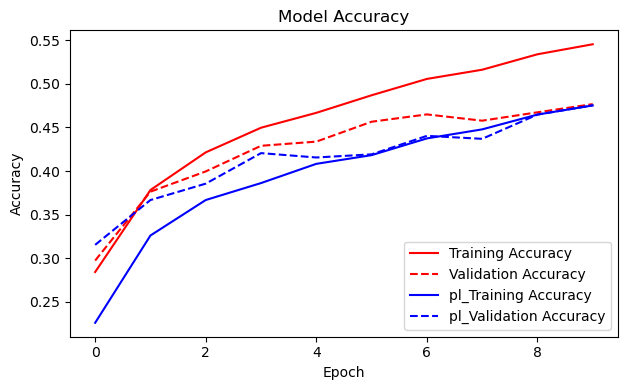

In [21]:
import matplotlib.pyplot as plt

# 绘制训练和验证的准确率曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'],"r-", label='Training Accuracy')
plt.plot(model.history.history['val_accuracy'],"r--", label='Validation Accuracy')
plt.plot(model2.history.history['accuracy'],"b-", label='pl_Training Accuracy')
plt.plot(model2.history.history['val_accuracy'],"b--", label='pl_Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# 使用SELU替换批量归一化，并进行必要的调整一确保网络是自归一化
tf.random.set_seed(42)
model4 = tf.keras.Sequential()
model4.add(tf.keras.layers.Input(shape=(32, 32, 3)))
model4.add(tf.keras.layers.Normalization()) # 批量标准化
model4.add(tf.keras.layers.Flatten()) # 因为Dense层需要输入扁平化数据

for layer in range(20):
    model4.add(tf.keras.layers.Dense(100,kernel_initializer="lecun_normal",activation="selu"))  # 密集层都使用selu，该网络就是自归一化的
model4.add(tf.keras.layers.Dense(10, activation="softmax"))

In [25]:
tf.keras.backend.clear_session()
# 模型编译(编译之前适配)、拟合

optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001,beta_1 = 0.9,beta_2 = 0.999)
early_callback = tf.keras.callbacks.EarlyStopping(patience=3)
model4.layers[0].adapt(x_train)
model4.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

model4.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_valid,y_valid),callbacks=[early_callback])

Epoch 1/10
1407/1407 [==============================] - 55s 25ms/step - loss: 1.9411 - accuracy: 0.2973 - val_loss: 1.7925 - val_accuracy: 0.3476
Epoch 2/10
1407/1407 [==============================] - 38s 27ms/step - loss: 1.7411 - accuracy: 0.3733 - val_loss: 1.7552 - val_accuracy: 0.3716
Epoch 3/10
1407/1407 [==============================] - 21s 15ms/step - loss: 1.6606 - accuracy: 0.4071 - val_loss: 1.7318 - val_accuracy: 0.3684
Epoch 4/10
1407/1407 [==============================] - 24s 17ms/step - loss: 1.5959 - accuracy: 0.4317 - val_loss: 1.6950 - val_accuracy: 0.4144
Epoch 5/10
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5565 - accuracy: 0.4516 - val_loss: 1.6015 - val_accuracy: 0.4350
Epoch 6/10
1407/1407 [==============================] - 26s 19ms/step - loss: 1.5144 - accuracy: 0.4670 - val_loss: 1.6295 - val_accuracy: 0.4358
Epoch 7/10
1407/1407 [==============================] - 23s 16ms/step - loss: 1.4871 - accuracy: 0.4739 - val_loss: 1.6742 -

In [28]:
# 使用dropout正则化模型
tf.random.set_seed(42)
model5 = tf.keras.Sequential()
model5.add(tf.keras.layers.Input(shape=(32, 32, 3)))
model5.add(tf.keras.layers.Normalization()) # 批量标准化
model5.add(tf.keras.layers.Flatten()) # 因为Dense层需要输入扁平化数据
model5.add(tf.keras.layers.Dropout(rate=0.2))
for layer in range(20):
    model5.add(tf.keras.layers.Dense(100,kernel_initializer="lecun_normal",activation="selu"))
    model5.add(tf.keras.layers.Dropout(rate=0.2))
model5.add(tf.keras.layers.Dense(10, activation="softmax"))

In [29]:
tf.keras.backend.clear_session()
# 模型编译(编译之前适配)、拟合

optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001,beta_1 = 0.9,beta_2 = 0.999)
early_callback = tf.keras.callbacks.EarlyStopping(patience=3)
model5.layers[0].adapt(x_train)
model5.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

model5.fit(x_train,y_train,epochs=10,batch_size=32,validation_data=(x_valid,y_valid),callbacks=[early_callback])

Epoch 1/10
1407/1407 [==============================] - 48s 24ms/step - loss: 2.4441 - accuracy: 0.1338 - val_loss: 2.1442 - val_accuracy: 0.1606
Epoch 2/10
1407/1407 [==============================] - 35s 25ms/step - loss: 2.1362 - accuracy: 0.1664 - val_loss: 2.0595 - val_accuracy: 0.1698
Epoch 3/10
1407/1407 [==============================] - 33s 23ms/step - loss: 2.0627 - accuracy: 0.1957 - val_loss: 2.0583 - val_accuracy: 0.2052
Epoch 4/10
1407/1407 [==============================] - 32s 22ms/step - loss: 2.0307 - accuracy: 0.2172 - val_loss: 1.9945 - val_accuracy: 0.2368
Epoch 5/10
1407/1407 [==============================] - 33s 23ms/step - loss: 2.0302 - accuracy: 0.2252 - val_loss: 1.9765 - val_accuracy: 0.2394
Epoch 6/10
1407/1407 [==============================] - 30s 22ms/step - loss: 1.9985 - accuracy: 0.2402 - val_loss: 1.9749 - val_accuracy: 0.2496
Epoch 7/10
1407/1407 [==============================] - 31s 22ms/step - loss: 1.9991 - accuracy: 0.2420 - val_loss: 2.0168 -